## Cassava Disease Classification

### 1. Import Libraries

Import necessary libraries for deep learning, data preprocessing, visualization, and managing datasets.

In [ ]:
pip install tensorflowjs

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet101V2

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import shutil

from google.colab import drive, files
from collections import defaultdict

### 2. Define Constants

Set constants for image size, batch size, number of classes, and epochs for training.

In [ ]:
# Constants
IMG_SIZE = 448
BATCH_SIZE = 32
NUM_CLASSES = 5
EPOCHS = 20

### 3. Define Dataset Paths

Define paths for training and testing datasets.

In [ ]:
# File Paths
BASE_DIR = '/content/data'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

### 4. Mount Google Drive

Mount Google Drive to access datasets stored in it.

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 5. Extract Dataset

Extract the training and testing datasets from ZIP files in Google Drive.

In [ ]:
# Extract Datasets
zip_path_train = '/content/drive/My Drive/capstone_project_datasets/cassava_train.zip'
zip_path_test = '/content/drive/My Drive/capstone_project_datasets/cassava_test.zip'

In [ ]:
if not os.path.exists(BASE_DIR):
    with zipfile.ZipFile(zip_path_train, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)
    with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
        zip_ref.extractall(BASE_DIR)

### 6. Load Dataset Paths and Labels

Collect file paths and labels for training images.

In [ ]:
# Load Data Paths and Labels
train_paths, train_labels = [], []
for root, _, files in os.walk(TRAIN_DIR):
    for file in files:
        train_paths.append(os.path.join(root, file))
        train_labels.append(root.split("/")[-1])

Collect file paths and labels for testing images.

In [ ]:
# Load Data Paths and Labels
test_paths, test_labels = [], []
for root, _, files in os.walk(TEST_DIR):
    for file in files:
        test_paths.append(os.path.join(root, file))
        test_labels.append(root.split("/")[-1])

### 7. Map Labels to Integers

Map disease class names to integer indices for compatibility with the model.

In [ ]:
label_index = {'cbb': 0, 'cbsd': 1, 'cgm': 2, 'cmd': 3, 'healthy': 4}
train_labels = [label_index[label] for label in train_labels]

### 8. Define Preprocessing and Augmentation Functions

Define a function to preprocess images (resizing, normalization, and one-hot encoding).

In [ ]:
def preprocess(image, label):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

Define a function for data augmentation.

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

### 9. Split Data

Split the dataset into training and validation sets with stratified sampling.

In [ ]:
# Split Data
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

### 10. Create TensorFlow Dataset

Define a function to create TensorFlow datasets with preprocessing and augmentation.

In [ ]:
# Define Dataset
def create_dataset(paths, labels, augment_data=False):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment_data:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

### 11. Prepare Training, Validation, and Test Datasets

Create datasets for training, validation, and testing.

In [ ]:
train_dataset = create_dataset(train_paths, train_labels, augment_data=True)
val_dataset = create_dataset(val_paths, val_labels)
#test_dataset = create_dataset(test_paths, test_labels)

### 12. Compute Class Weights

Compute class weights to handle class imbalance during training.

In [ ]:
# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

### 13. Define the Model

Define the ResNet101V2-based model architecture with custom classification layers.

In [ ]:
# Model Definition
def create_model():
    base_model = ResNet101V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base layers

    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### 14. Implement K-Fold Cross-Validation

Initialize K-Fold cross-validation with 6 splits.

In [ ]:
# K-Fold Cross Validation
k_folds = 6
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_paths_np = np.array(train_paths)
train_labels_np = np.array(train_labels)

validation_accuracies = []

### 15. Train the Model

Train the model for each fold and store validation accuracies.

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(train_paths_np), 1):
    print(f"Training on Fold {fold}/{k_folds}...")
    train_fold_paths, val_fold_paths = train_paths_np[train_idx], train_paths_np[val_idx]
    train_fold_labels, val_fold_labels = train_labels_np[train_idx], train_labels_np[val_idx]

    train_dataset = create_dataset(train_fold_paths, train_fold_labels, augment_data=True)
    val_dataset = create_dataset(val_fold_paths, val_fold_labels)

    model = create_model()

    # Training
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        class_weight=class_weights,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    # Validation Accuracy
    val_accuracy = history.history['val_accuracy'][-1]
    validation_accuracies.append(val_accuracy)
    print(f"Fold {fold} - Validation Accuracy: {val_accuracy:.4f}")

Training on Fold 1/6...
Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 59s 295ms/step - accuracy: 0.3048 - loss: 13.4315 - val_accuracy: 0.4271 - val_loss: 12.2280
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.4942 - loss: 12.0843 - val_accuracy: 0.5093 - val_loss: 11.5267
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.5498 - loss: 11.4256 - val_accuracy: 0.5875 - val_loss: 10.9671
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6076 - loss: 10.8031 - val_accuracy: 0.6446 - val_loss: 10.4719
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6239 - loss: 10.3565 - val_accuracy: 0.6711 - val_loss: 10.0526
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6655 - loss: 9.9002 - val_accuracy: 0.6950 - val_loss: 9.6453
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.6961 - loss: 9.5109 - val_accuracy: 0.7095 - val_loss: 9.3052
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step -

In [ ]:
# Mean Validation Accuracy
mean_val_accuracy = np.mean(validation_accuracies)
print(f"\n6-Fold Cross-Validation - Mean Validation Accuracy: {mean_val_accuracy:.4f}")


6-Fold Cross-Validation - Mean Validation Accuracy: 0.7816


### 16. Evaluate the Model

Evaluate the model on the validation dataset.

In [ ]:
# Evaluate on the validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate on the test dataset (if available)
#test_loss, test_accuracy = model.evaluate(test_data, verbose=1)  # Assuming test_data is defined
#print(f"Test Loss: {test_loss:.4f}")
#print(f"Test Accuracy: {test_accuracy:.4f}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.7752 - loss: 5.5578
Validation Loss: 5.5678
Validation Accuracy: 0.7931


### 17. Visualize Metrics

Plot training and validation accuracy and loss over epochs.

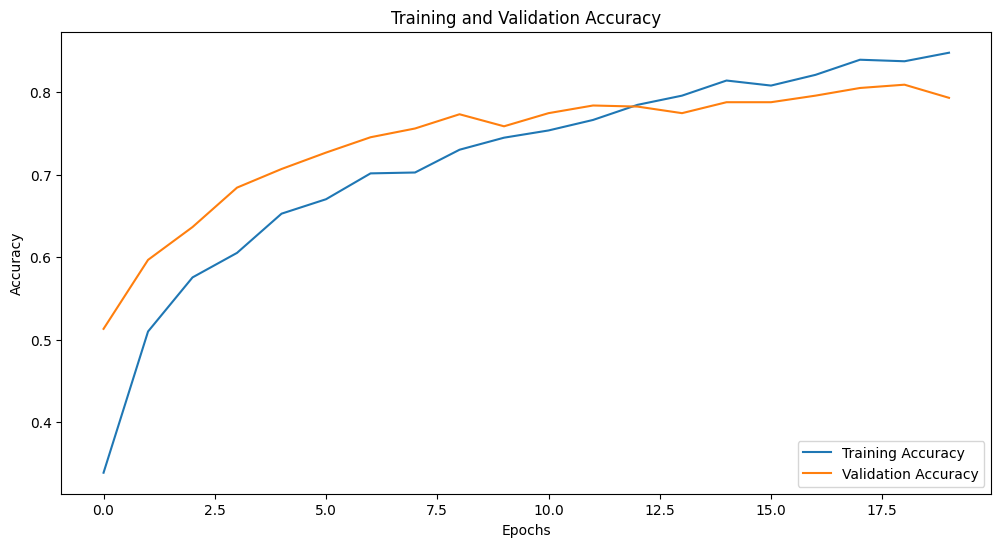

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

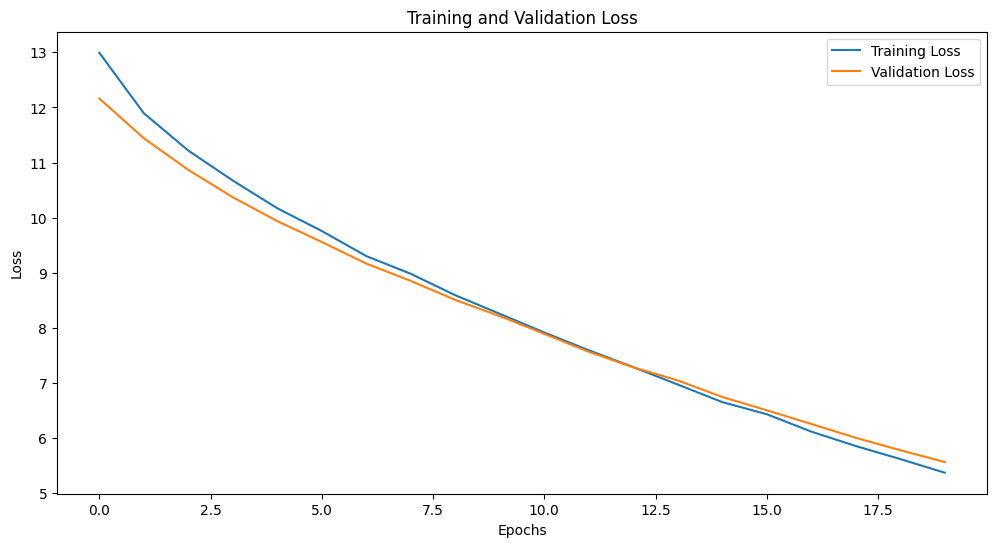

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 18. Generate Predictions

Predict class probabilities for the validation dataset.

In [ ]:
# Predict on the validation dataset
y_pred_probs = model.predict(val_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()  # Get predicted class indices

# Get true labels
y_true = []
for _, labels in val_dataset:
    y_true.extend(tf.argmax(labels, axis=1).numpy())  # Assuming one-hot encoding
y_true = np.array(y_true)

# Print predictions vs actuals for inspection (optional)
print("Predicted:", y_pred[:10])
print("Actual:", y_true[:10])


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 304ms/step
Predicted: [3 2 0 3 3 2 4 3 4 3]
Actual: [3 1 2 1 2 3 3 2 4 1]


Find the indices where the predicted labels match the true labels.

In [ ]:
correct_indices = np.where(y_pred == y_true)[0]

Organize the correctly predicted images by their true class labels.

In [ ]:
# Group images by class
correct_paths_by_class = defaultdict(list)

file_paths = []
for file_path, label in val_dataset.unbatch():
    file_paths.append(file_path.numpy())

# Loop through correct indices and group by class
for idx in correct_indices:
    class_label = y_true[idx]
    correct_paths_by_class[class_label].append(image_paths[idx])

NameError: name 'image_paths' is not defined

Ensure each class has at least 12 correctly predicted images. If fewer than 9 are available, select all.

In [1]:
selected_paths_by_class = {}

for class_label, paths in correct_paths_by_class.items():
    selected_paths_by_class[class_label] = paths[:9]

NameError: name 'correct_paths_by_class' is not defined

Visualize the selected images for each class or save their paths/names.

In [ ]:
# Define class names
class_names = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

# Plot the images
#for class_label, images in selected_images_by_class.items():
 #   plt.figure(figsize=(15, 10))
  #  plt.suptitle(f"Correctly Predicted: {class_names[class_label]}")
#
 #   for i, image in enumerate(images):
  #      plt.subplot(3, 3, i + 1)
   #     plt.imshow(image)
    #    plt.axis('off')
#
 #   plt.show()

Print image paths.

In [ ]:
# Select up to 9 file paths for each class
selected_paths_by_class = {}
for class_label, paths in correct_paths_by_class.items():
    selected_paths_by_class[class_label] = paths[:9]  # Take the first 9 or fewer

# Print file paths
for class_label, paths in selected_paths_by_class.items():
    print(f"Class {class_label}:")
    for path in paths:
        print(path)

### 19. Classification Report

Generate a classification report.

In [ ]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=['cbb', 'cbsd', 'cgm', 'cmd', 'healthy'])
print(report)


              precision    recall  f1-score   support

         cbb       0.05      0.04      0.05        69
        cbsd       0.21      0.24      0.22       178
         cgm       0.12      0.11      0.12       110
         cmd       0.45      0.42      0.43       356
     healthy       0.11      0.15      0.12        41

    accuracy                           0.28       754
   macro avg       0.19      0.19      0.19       754
weighted avg       0.29      0.28      0.28       754



### 20. Confusion Matrix

Generate confusion matrix.

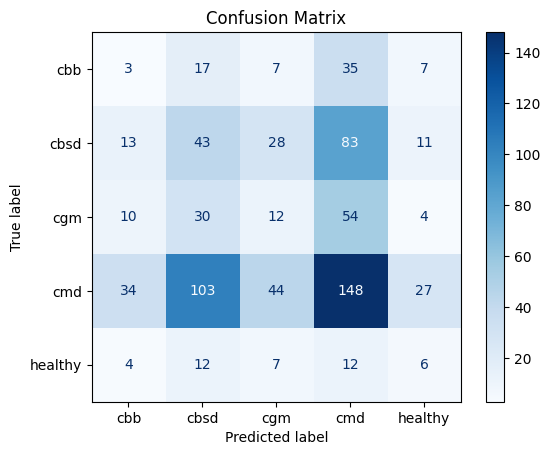

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['cbb', 'cbsd', 'cgm', 'cmd', 'healthy'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### 21. Misclassified

Compare the predicted labels `y_pred` with the true labels `y_true` and extract indices where the predictions are incorrect.

In [ ]:
misclassified_indices = np.where(y_pred != y_true)[0]

Pick the first 12 misclassified images (or fewer if there are not enough).

In [ ]:
image_paths = []  # Store image paths for visualization
for images, labels in val_dataset.unbatch():
    image_paths.append(images.numpy())

In [ ]:
num_misclassified = min(len(misclassified_indices), 12)
misclassified_images = [image_paths[i] for i in misclassified_indices[:num_misclassified]]
misclassified_true_labels = [y_true[i] for i in misclassified_indices[:num_misclassified]]
misclassified_pred_labels = [y_pred[i] for i in misclassified_indices[:num_misclassified]]

Plot the misclassified images with their true and predicted labels.

In [ ]:
class_names = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

plt.figure(figsize=(15, 10))
for i in range(num_misclassified):
    plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
    image = misclassified_images[i]
    plt.imshow(image)
    plt.title(f"True: {class_names[misclassified_true_labels[i]]}\nPred: {class_names[misclassified_pred_labels[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 22. Save the Model

Save the trained model for future use.

In [ ]:
model.save("cassava_disease_model_2.h5")

### 23. Convert to TensorFlow.js Model

Install TensorFlow.js Converter.

In [ ]:
#pip install tensorflowjs

Convert the Keras H5 model to TensorFlow.js Format.

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model cassava_disease_model cassava_disease_model_js_new

2024-12-07 05:57:42.895303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733551062.917796   31326 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733551062.924410   31326 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-12-07 05:57:46.617795: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1733551066.617929   31326 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

### 24. Compress the Model Folder and Download It

Compres the folder.

In [ ]:
shutil.make_archive('cassava_gatau_js', 'zip', 'cassava_gatau_js')

'/content/cassava_gatau_js.zip'

Download the `.zip` file.

In [ ]:
files.download('cassava_gatau_js.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>